In [1]:
## imports used 
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import glob
from datetime import datetime
import getpass
## only relevent if used in a Jupyter Notebook
#%matplotlib inline

## requires SHARPpy to be installed!
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

from matplotlib.ticker import (MultipleLocator, NullFormatter,ScalarFormatter)
## manually defined the site names used in the file names because I'm lazy
sites = ["Hillsboro, KS", "Lamont, OK", "Morris, OK", "Purcell, OK", "Vici, OK", "Homestead, OK", "Norman, OK", "Dodge City, KS", "FP4", "FP5", "Topeka, KS"]

/Users/khalbert/anaconda/lib/python2.7/site-packages/SHARPpy-1.4.0-py2.7.egg/sharppy/sharptab/winds.py:14: UserWarning: Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)
  warnings.warn("Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)")


In [89]:
def get_site_files(sitename):
    """Returns all files at a given site"""
    files = sorted(glob.glob(sitename + " *.txt"))
    return files
    
def read_kevins_file(filename):
    """Kevin's bore files are slightly different than ihop soundings"""
    data = np.genfromtxt(filename, dtype=float, delimiter=",", usecols=(0,1,2,3,4,5,6))
    return data

def read_sounding_file(filename):
    """Read in the ihop soundings"""
    data = np.genfromtxt(filename, dtype=None, skip_header=15, usecols=(1, 2, 3, 5, 6, 14))
    return data

def read_wyoming_file(filename):
    """Use this if reading in data from the University of Wyoming"""
    data = np.genfromtxt(filename, dtype=float, skip_header=0, usecols=(0, 1, 2, 3, 6, 7))
    return data

def lift_parcels(prof):
    """Lift all the parcels within a given height interval and return the CAPEs, CINHs, and LFCs"""
    ## the height bottom, top, and interval
    zvals = np.arange(0, 5000, 100)
    pvals = interp.pres(prof, interp.to_msl(prof, zvals))
    
    tvals = interp.temp(prof, pvals)
    dvals = interp.dwpt(prof, pvals)
    hvals = interp.hght(prof, pvals)
    hvals = interp.to_agl(prof, hvals)
    
    ## empty lists for storing the result
    cape_arr = []
    cinh_arr = []
    lfc_arr = []
    
    ## lift each parcel in the vertical profile
    for p, t, td, h in zip(pvals, tvals, dvals, hvals):
        ## use SHARPpy to compute the parcel indices
        pcl = params.parcelx(prof, pres=p, tmpc=t, dwpc=td)
        
        ## store the parcel indices
        cape_arr.append(pcl.bplus)
        cinh_arr.append(pcl.bminus)
        lfc_arr.append(pcl.lfchght - h)
    
    ## return the data
    return np.ma.masked_invalid(cape_arr), np.ma.masked_invalid(cinh_arr), np.ma.masked_invalid(lfc_arr)

    
def process_site(file):
    try:
        ## switch out the reading function for the anticipated data type
        data = read_wyoming_file(file)
        #data = read_sounding_file(file)
        
        ## depending on the data reader used, different block of code is requires
        #"""
        p = data[:, 0]
        Z = data[:, 1]
        T = data[:, 2]
        Td = data[:, 3]
        U = np.zeros(T.shape)
        V = np.zeros(T.shape)
        """
        
        p = data[:, 0]
        T = data[:, 1]
        Td = data[:, 2]
        Z = data[:, 5]
        U = np.zeros(T.shape)
        V = np.zeros(T.shape)
        """
        ## comment out this triple quote if using the above block
        
        dz = None
        p_og = None
        z_og = None
        
        p[p == 9999.0] = np.nan
        T[T == 999.0] = np.nan
        Td[Td == 999.0] = np.nan
        Z[Z == 9999.0] = np.nan
        
        
        p = np.ma.masked_invalid(p)
        T = np.ma.masked_invalid(T)
        Td = np.ma.masked_invalid(Td)
        Z = np.ma.masked_invalid(Z)
        
    except:
        ## read in Kevins beautiful data
        data = read_kevins_file(file)
        Z = data[:, 0]
        p = data[:, 1]
        T = data[:, 2]
        U = np.zeros(T.shape)
        V = np.zeros(T.shape)
        Td = data[:, 3]
        
        dz = data[:, 4][::10]
        p_og = data[:, 5][::10]
        z_og = data[:, 6][::10]
        
        p = np.ma.masked_invalid(p)
        T = np.ma.masked_invalid(T)
        Td = np.ma.masked_invalid(Td)
        Z = np.ma.masked_invalid(Z)
    print file
    
    ## create profile object for processing
    prof = profile.create_profile(profile='default', pres=p, hght=Z, tmpc=T, \
                                        dwpc=Td, u=U, v=V, strictQC=False)
    
    if dz is not None:
        pvals = interp.pres(prof, interp.to_msl(prof, np.arange(0, 5000, 100)))
        dz = interp.generic_interp_pres(np.log10(pvals), np.log10(p_og)[::-1], dz[::-1])
    print dz
    ## return the lifted parcel indices and the bore dz
    return lift_parcels(prof), dz
    
    
def toFile(file_name, prof):
    """Here if for some reason you need to save a profile object to the disk"""
    def qc(val):
            return -9999. if not utils.QC(val) else val
    
    snd_file = open(file_name, 'w')
    snd_loc ="TOP"

    now = datetime.utcnow()
    user = getpass.getuser()
    snd_file.write("%TITLE%\n")
    snd_file.write("%s   \n Saved by user: %s on %s UTC\n" % (snd_loc, user, now.strftime('%Y%m%d/%H%M')))
    snd_file.write("   LEVEL       HGHT       TEMP       DWPT       WDIR       WSPD\n")
    snd_file.write("-------------------------------------------------------------------\n")
    snd_file.write("%RAW%\n")
    for idx in xrange(prof.pres.shape[0]):
        str = ""
        for col in ['pres', 'hght', 'tmpc', 'dwpc', 'wdir', 'wspd']:
            str += "%8.2f,  " % qc(prof.__dict__[col][idx])

        snd_file.write(str[:-3] + "\n")
    snd_file.write("%END%\n")
    snd_file.close()

In [94]:
def plot_conv_height(site):
    """This is my hodgepodge, manually defined way to process everything. 
    Sorry in advance."""
    
    file = "DDC_2015_06_03_12:00:00.txt"#+ " 2002, 06, 04, 11:29:00.txt"
    print file
    lift_file = "DDC_06_03_2015_12:00:00_lifted_h1_1100m_pred.csv"
    lifted_parcels = process_site(file)
    lifted_parcels_2 = process_site(lift_file)
    #lifted_observed = process_site("FP5_06_03_2015_06:12:43_lifted_h1_1100m_obs.csv")
    dz = lifted_parcels_2[1]


    hght = np.arange(0, 5000, 100)
    cape = lifted_parcels[0][0]
    print cape
    cinh = lifted_parcels[0][1]
    lfc = lifted_parcels[0][2]
    lcape = lifted_parcels_2[0][0]
    lcinh = lifted_parcels_2[0][1]
    llfc = lifted_parcels_2[0][2]
    #ocape = lifted_observed[0][0]
    #ocinh = lifted_observed[0][1]
    #olfc = lifted_observed[0][2]

    ## everything below is all plotting related
    fig = plt.figure(figsize=(10,10))
    ax1 = plt.subplot(1,3,1)
    ax1.plot(cape, hght, color="#DF8585", linestyle='-', linewidth=2, label="undisturbed")
    ax1.plot(lcape, hght, color="#B00000", linestyle='--', linewidth=3, label="Theor. bore lift")
    #ax1.plot(ocape, hght, color="#DF8585", linestyle=':', linewidth=2, label="disturbed")

    ax1.set_ylim(0,3000)
    ax1.set_xlim(-50,3500)
    ax1.set_xlabel("CAPE (J kg^-1)")
    ax1.set_ylabel("Height (m AGL)")
    ax1.legend()


    ax2 = plt.subplot(1,3,2)
    ax2.plot(cinh, hght, color="#60A0E4", linestyle='-', linewidth=2, label="undisturbed")
    ax2.plot(lcinh, hght, color="#001BFF", linestyle='--', linewidth=3, label="Theor. bore lift")
    #ax2.plot(ocinh, hght, color="#60A0E4", linestyle=':', linewidth=2, label="disturbed")


    ax2.set_ylim(0,3000)
    ax2.set_xlim(-800, 50)
    ax2.set_xlabel("CINH (J kg^-1)")
    ax2.legend()
    
    ax3 = plt.subplot(1,3,3)
    ax3.plot(lfc, hght, 's', markeredgecolor="#FB00FF", markerfacecolor='None', markersize=15, markeredgewidth=2, label="undisturbed")
    ax3.plot(llfc, hght, 'o', markeredgecolor="k", markerfacecolor='None', markersize=15, markeredgewidth=2, label="Theor. bore lift")
    #ax3.plot(olfc, hght, 'x', color='#FB00FF', markersize=10, markeredgewidth=2, label="disturbed")
    ax3.plot(dz, hght, 'ko', label="Bore displ.")

    ax3.set_ylim(0,3000)
    ax3.set_xlim(0, 4000)
    ax3.set_xlabel("LFC - LPL (m)")
    ax3.legend()


    plt.suptitle(site + " 03 June 2015\n1200 UTC")


    #plt.tight_layout()
    plt.savefig(site + " cape-cin_comp.png", bbox_inches="tight")
    plt.show()
    plt.clf()
    plt.close()

DDC_2015_06_03_12:00:00.txt
DDC_2015_06_03_12:00:00.txt
None
DDC_06_03_2015_12:00:00_lifted_h1_1100m_pred.csv
[   0.            8.45964907   16.91929814   25.37732657   33.83347608
   42.2896256    50.71648448   58.97467661   67.2321785    75.51768582
   83.80923409   92.10976381  100.4997008   103.92        103.92        103.92
  103.92        103.92        103.92        103.92        103.92        103.92
  103.92        103.92        103.92        103.92        103.92        103.92
  103.92        103.92        103.92        103.92        103.92        103.92
  103.92        103.92        103.92        103.92        103.92        103.92
  103.92        103.92        103.92        103.92        103.92        103.92
  103.92        103.92        103.92        103.92      ]
[792.252165121697 647.8815587702583 589.7385549605171 862.460042957646
 1159.2694007434584 1571.6354103747196 2016.687346648832 1334.1863146305197
 1028.5993878041434 856.2330111776513 824.1235983920808 622.776133542

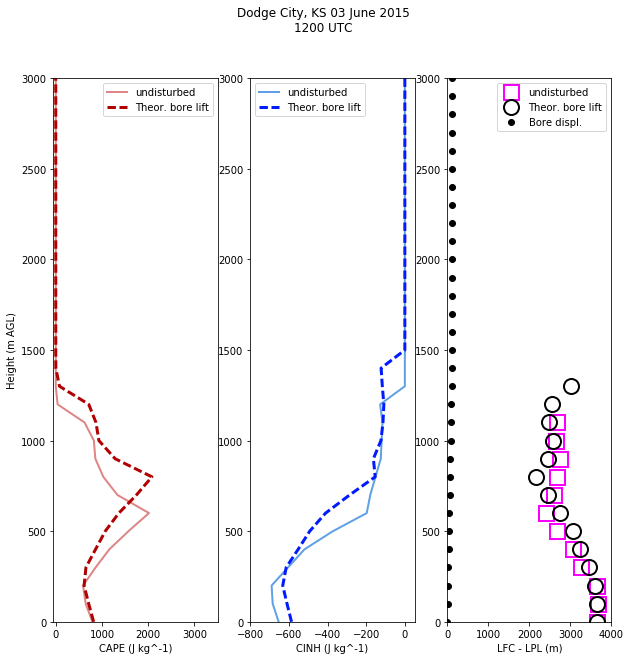

In [95]:
plot_conv_height(sites[-4])